In [1]:
%load_ext watermark
import pandas as pd
import session_config
import reports
import roughdraft
import geospatial
from session_config import lat_lon
from gridforecast import SampleSelector

import geopandas as gpd
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from shapely import Point
from shapely import unary_union

# Land cover and land use 

_The land cover and land use are used to determine the similarity of one survey location to another. In this way we can evaluate the probable minimum amount of trash at a given location based on the physical environment._

Land cover and land use provide information about the physical characteristics of a survey location. The land use and cover is measured by considering the proportion of land dedicated to specific purposes within a radius of 1'500 m of the survey location of interest. The specific puroposes are defined by the following map layers available at [swissTLMRegio](https://www.swisstopo.admin.ch/en/landscape-model-swisstlmregio):

1. Landcover (TLM_BODENBEDECKUNG)
2. Streets (TLM_STRASSEN)
3. Hydrology (TLM_GEWAESSER)
4. Sports and recreation (TLM_FREIZEITAREAL)
5. Public services (TLM_NUTZUNGSAREAL)

## Defining similar locations

When comparing feature vectors in three-dimensional space, various distance metrics can be applied, each depending on the nature of the data and the type of comparison needed. **Euclidean distance** measures the straight-line distance between two points, making it suitable when the magnitude of differences in the same-scale features matters. **Manhattan distance** measures the sum of absolute differences across each dimension, which is useful when you prefer a more "axis-aligned" measure of difference, particularly when feature importance might vary along each axis. **Cosine similarity**, however, compares the orientation of the vectors in space, measuring how aligned they are regardless of magnitude. This is particularly relevant when the proportions between feature values are more important than their absolute values. In our analysis, cosine similarity was chosen because we are more interested in the relative proportions of the feature variables rather than their magnitudes.

Cosine similarity measures the cosine of the angle between two vectors in multi-dimensional space, focusing on the direction of the vectors rather than their length. The similarity ranges from -1 (perfectly opposite directions) to 1 (identical directions), with 0 indicating orthogonal or no similarity. The formula normalizes the vectors to unit length, comparing only the relative proportions between the dimensions. Cosine similarity is especially useful when the magnitude of the vectors varies significantly, but the pattern or trend of the features is important.

For example, imagine comparing two feature vectors:

- $ x = [0.4, 0.5, 0.6] $  
- $y = [0.2, 0.25, 0.3] $

Even though the absolute values of \(y\) are smaller than those of \(x\), the proportions between dimensions remain the same (i.e., $ 0.4/0.5 \approx 0.2/0.25$)). Cosine similarity will show that these two vectors are highly similar because their pattern or direction is nearly identical. By contrast, Euclidean distance would highlight the magnitude differences between the vectors, leading to a different measure of similarity.

## Example: defining the land use for one location

For each location the land use and land cover is calculated by first extracting the relevant features from the appropriate map layers within a radius of 1 500 m.

In [10]:


gpd.options.io_engine = "pyogrio"


land_covers = [
        "Wald",
        "See",
        "Stausee",
        "Siedl",
        "Stadtzentr.",
        "Sumpf",
        "Obstanlage",
        "Reben",
        "recreation",
        'public-services',
        'undefined'
    ]

def a_point_buffer(this_location, buffer_radius: int = 1500, coordinate_crs: str = 'epsg:4326', to_crs: str = "epsg:2056"):
    
    if isinstance(this_location, dict):
        this_location = pd.DataFrame([this_location])
        this_geometry = [Point(this_location['longitude'], this_location['latitude'])]

    if isinstance(this_location, pd.Series):
        this_geometry = [Point(this_location.longitude, this_location.latitude)]
    
    this_shape = gpd.GeoDataFrame(this_location, geometry=this_geometry, crs=coordinate_crs)
    this_shape = this_shape.to_crs(to_crs)

    this_buffer = gpd.GeoDataFrame(geometry=this_shape.buffer(1500), crs=to_crs)
    location_buffer = this_buffer.dissolve()
    return this_shape, location_buffer, location_buffer.total_bounds


def location_geo_attributes(bounds, buffer, shape_file, objcolumn: str = 'OBJVAL', objval: str ='land-cover', buffer_name: str = None):
    minx, miny, maxx, maxy = bounds
    landcover = gpd.read_file(shape_file, bbox=(minx, miny, maxx, maxy))
    landcover = landcover.drop_duplicates()
    landcover = gpd.overlay(landcover, buffer, how='intersection', keep_geom_type=True)
    landcover.rename(columns={objcolumn:objval}, inplace=True)
    
    landcover['buffer-name'] = buffer_name
    return landcover[['buffer-name', objval, 'geometry']], landcover['land-cover'].unique()

def assign_colors_to_polygons(buffer_contents: gpd.GeoDataFrame, colors: dict = None, objval: str = None):
    buffer_contents['color'] = buffer_contents[objval].map(colors)
    return buffer_contents
    
def compute_landuse_percent_of_buffer(buffer_contents, buffer_area):

    land_covers = buffer_contents['land-cover'].unique()

    if 'Stausee' in land_covers:
        
        if 'See' in land_covers:
            see_stausee_gdf = buffer_contents[buffer_contents['land-cover'].isin(['See', 'Stausee'])]
            combined_geometry = unary_union(see_stausee_gdf['geometry'])
            new_row = {
                'buffer-name': buffer_contents['buffer-name'].unique()[0],
                'land-cover': 'See',
                'geometry': combined_geometry
            }
            buffer_contents = buffer_contents[~buffer_contents['land-cover'].isin(['See', 'Stausee'])]
            
            new_gdf = gpd.GeoDataFrame([new_row], columns=buffer_contents.columns, crs=buffer_contents.crs)

            # Concatenate the original GeoDataFrame with the new GeoDataFrame
            buffer_contents = pd.concat([buffer_contents, new_gdf], ignore_index=True)
            
        else:
            see_stausee_gdf = buffer_contents[buffer_contents['land-cover'].isin(['Stausee'])]
            a_geometry = unary_union(see_stausee_gdf['geometry'])
            new_row = {
                'buffer-name': buffer_contents['buffer-name'].unique()[0],
                'land-cover': 'See',
                'geometry': a_geometry
            }
            buffer_contents = buffer_contents[~buffer_contents['land-cover'].isin(['See', 'Stausee'])]
            
            new_gdf = gpd.GeoDataFrame([new_row], columns=buffer_contents.columns, crs=buffer_contents.crs)

            buffer_contents = pd.concat([buffer_contents, new_gdf], ignore_index=True)
            

    elif 'See' in buffer_contents['land-cover'].unique():
        water_surface = buffer_contents.loc[buffer_contents['land-cover'] == 'See', 'geometry'].geometry.area.values[0]
        buffer_contents['buffer-area-dry'] = buffer_area - water_surface
        buffer_contents['area_m2'] = buffer_contents.geometry.area
        buffer_contents['buffer-area-dry'] = buffer_area - water_surface
        buffer_contents['rate'] = buffer_contents.area_m2/buffer_contents['buffer-area-dry']

    else:
        buffer_contents['area_m2'] = buffer_contents.geometry.area
        buffer_contents['buffer-area-dry'] = buffer_area
        buffer_contents['rate'] = buffer_contents.area_m2/buffer_contents['buffer-area-dry']    
    
    return buffer_contents

def compute_undefined_sections_of_buffer(buffer, buffer_contents, objval: str = 'land-cover', buffer_name: str = 'None'):
    undefined = buffer.geometry.iloc[0]
    
    for aval in buffer_contents.geometry:
        undefined = undefined.difference(aval)
    args = {
        'geometry':[undefined],
        objval : ['undefined'],
        'buffer-name':[ buffer_name]
    }
    undef = gpd.GeoDataFrame(args, crs=buffer.crs)

    return undef


landuse_trans = {
    'Wald': 'forest',
    'Fels': 'ravines',
    'Geroell': 'boulders',
    'Gletscher': 'glacier',
    'Stausee': 'reservoir',
    'See': 'lake',
    'Reben': 'vineyards',
    'Obstanlage': 'orchards',
    'Siedl': 'buildings',
    'Sumpf': 'wetlands',
    'undefined': 'undefined',
    'streets': 'streets',
    'recreation': 'recreation',
    'public-services': 'public-services',
    'location' : 'location'
    
}

landuse_color = {
    'forest': 'olivedrab',
    'ravines': 'gray',
    'boulders': 'gray',
    'glacier': 'gray',
    'reservoir': 'dodgerblue',
    'lake': 'dodgerblue',
    'vineyards': 'seagreen',
    'orchards': 'yellowgreen',
    'buildings': 'slategray',
    'wetlands': 'yellow',
    'undefined': 'khaki',
    'recreation': 'red',
    'public-services': 'magenta',
    'rivers': 'dodgerblue',
    'streets': 'black'
}


class RandomPointLanduse:

    def __init__(self, name, latitude, longitude, feature_type):
        self.lat = latitude
        self.lon = longitude
        self.feature_type = feature_type
        self.name = name
        self.point = None
        self.buffer = None
        self.bounds = None
        self.buffer_content = None

    def point_buffer_bounds(self, **kwargs):
        lat_lon = {'latitude':self.lat, 'longitude': self.lon}
        this_point, abuffer, bufferbounds = a_point_buffer(lat_lon)
        self.point = this_point
        self.buffer = abuffer
        self.bounds = bufferbounds

    def land_cover(self, **kwargs):
        buffer_content, _ = location_geo_attributes(self.bounds, self.buffer, 'data/ignorethis/shapes/landcover.shp', buffer_name=self.name, **kwargs)
        self.buffer_content = buffer_content

    def public_services(self, **kwargs):
        # public services
        args = dict(objcolumn='OBJEKTART', objval='land-cover', buffer_name=self.name)
        nz, _ = location_geo_attributes(self.bounds, self.buffer, 'data/ignorethis/shapes/nutuzungsareal.shp', **args, **kwargs)
        nz_comb = unary_union(nz.geometry)
        nz_comb = gpd.GeoDataFrame([{'geometry': nz_comb, 'buffer-name':self.name, 'land-cover': 'public-services' }], crs=self.buffer_content.crs)
        buffer_content = pd.concat([self.buffer_content, nz_comb])
        self.buffer_content

    def recreation(self, **kwargs):
        args = dict(objcolumn='OBJEKTART', objval='land-cover', buffer_name=self.name)
        fz,_ = location_geo_attributes(self.bounds, self.buffer,'data/ignorethis/shapes/freizeit.shp', **args, **kwargs)
        fz_comb = unary_union(fz.geometry)
        fz_comb = gpd.GeoDataFrame([{'geometry': fz_comb, 'buffer-name':self.name, 'land-cover': 'recreation' }], crs=self.buffer_content.crs)
        buffer_content = pd.concat([self.buffer_content, fz_comb])
        self.buffer_content = buffer_content        
    
    def undefined_areas(self, **kwargs):        
        combined_polygon = unary_union(self.buffer_content.geometry)
        combined_Pn = gpd.GeoDataFrame({'geometry': [combined_polygon]}, crs=self.buffer_content.crs)
        undefined = compute_undefined_sections_of_buffer(self.buffer, combined_Pn, buffer_name=self.name)
        # combine the known land cover with the undefined
        buffer_content = pd.concat([self.buffer_content, undefined])
        self.buffer_content = buffer_content

    def streets(self, **kwargs):        

        minx, miny, maxx, maxy = self.bounds
        streets = gpd.read_file('data/ignorethis/shapes/strasse.shp',bbox=(minx, miny, maxx, maxy))
        
        streets = gpd.overlay(streets, self.buffer, how='intersection', keep_geom_type=True)
        streets = streets.drop_duplicates()
        # print(streets)
        streets = streets.dissolve()
        st_comb = gpd.GeoDataFrame([{'geometry': streets.geometry.values[0], 'buffer-name':self.name, 'land-cover': 'streets' }], crs=self.buffer_content.crs)
        st_result = pd.DataFrame([{'land-cover': 'streets', 'rate': 0, 'meters': st_comb.geometry.length, 'buffer-name':self.name}])
        buffer_content = pd.concat([self.buffer_content, st_comb])
        self.buffer_content = buffer_content
        return st_result

    def buffer_composition_proportions(self):

        self.point_buffer_bounds()
        self.land_cover()
        self.public_services()
        self.recreation()
    
        t = compute_landuse_percent_of_buffer(self.buffer_content.copy(), self.buffer.geometry.area[0])
        surface_columns = [x for x in t['land-cover'].unique() if x in land_covers]
        t = t[t['land-cover'].isin(surface_columns)].groupby('land-cover').agg({'rate':'sum', 'area_m2': 'sum'})    
        t = pd.DataFrame(t['rate']).T
        t['location'] = self.name
        t.reset_index(inplace=True, drop=True)
        st_result = self.streets()
        t['streets'] = st_result.loc[0, 'meters'][0]

        t.columns = [landuse_trans[x] for x in t.columns]
        new_column_order =['location', *[x for x in t.columns if x != 'location']]
        bcx = self.buffer_content
        bcx['land-cover'] = bcx['land-cover'].apply(lambda x: landuse_trans[x])
        self.buffer_content = bcx
        # t.rename(columns={'Siedl':'buildings', 'Wald':'forest'}, inplace=True)

        return t[new_column_order]


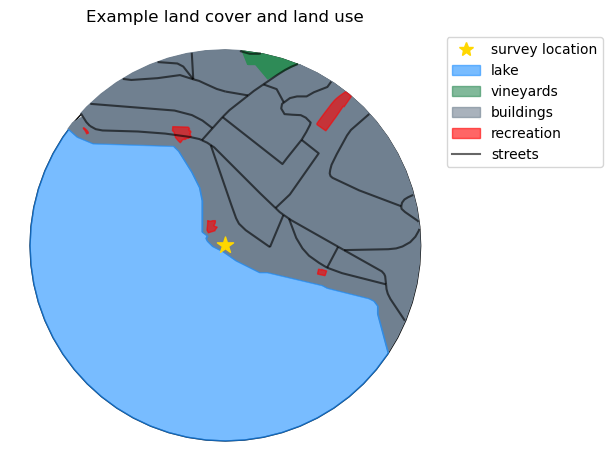

In [3]:
def plot_buffer_content(random_point_object, title: str = 'Example land cover and land use'):

    bc = random_point_object.buffer_content
    to_plot = bc['land-cover'].unique()
    legend = []

    fig, ax = plt.subplots()

    random_point_object.buffer.plot(ax=ax, facecolor='white', edgecolor='black', zorder=0)
    random_point_object.point.plot(ax=ax, marker='*', facecolor='gold', markersize=150, edgecolor='gold', zorder=6)
    legendentry = mlines.Line2D([], [], color='gold', marker='*', linestyle='None',  markersize=10, label='survey location')
    legend = [legendentry]
    
    for ashape in to_plot:
               
        if ashape in ['forest', 'buildings', 'vineyards', 'orchards', 'wetlands', 'ravines', 'boulders', 'glacier', 'undefined']:
            bc[bc['land-cover'] == ashape].plot(ax=ax, facecolor=landuse_color[ashape], edgecolor=landuse_color[ashape], alpha=1, zorder=1)
            legendentry = mpatches.Patch(facecolor=landuse_color[ashape], edgecolor=landuse_color[ashape], label=ashape, alpha=.6)
            legend.append(legendentry)
        
        if ashape in ['recreation', 'public-services']:
            bc[bc['land-cover'] == ashape].plot(ax=ax, facecolor=landuse_color[ashape], edgecolor=landuse_color[ashape], alpha=.6, zorder=2)
            legendentry = mpatches.Patch(facecolor=landuse_color[ashape], edgecolor=landuse_color[ashape], label=ashape, alpha=.6)
            legend.append(legendentry)

        if ashape in ['rivers']:
            bc[bc['land-cover'] == ashape].plot(ax=ax, facecolor=landuse_color[ashape], edgecolor=landuse_color[ashape], alpha=.6, zorder=3)
            legendentry = mlines.Line2D([], [], color=landuse_color[ashape], label=ashape, alpha=.6)
            legend.append(legendentry)
        
        if ashape in ['streets']:
            bc[bc['land-cover'] == ashape].plot(ax=ax, edgecolor=landuse_color[ashape], alpha=.6, zorder=4)
            legendentry = mlines.Line2D([], [], color=landuse_color[ashape], label=ashape, alpha=.6)
            legend.append(legendentry)
        if ashape in ['lake']:
            bc[bc['land-cover'] == ashape].plot(ax=ax, facecolor=landuse_color[ashape], edgecolor=landuse_color[ashape], alpha=.6, zorder=5)
            legendentry = mpatches.Patch(facecolor=landuse_color[ashape], edgecolor=landuse_color[ashape], label=ashape, alpha=.6)
            legend.append(legendentry)

    
    ax.axis('off')
    ax.set_title(title)
    ax.legend(handles=legend, bbox_to_anchor=(1, 1), loc='upper left')
    plt.tight_layout()

    plt.close()
    return fig
            



random_loc = 'quai-maria-belgia'
lat, lon = lat_lon.loc[random_loc,['latitude', 'longitude']]
arandompoint = RandomPointLanduse(random_loc, lat, lon, 'l')
t = arandompoint.buffer_composition_proportions()


plot_buffer_content(arandompoint)   

### Land use profile

The land use profile is the array of values between 0 and 1 that contains the proportion of the buffer zone occupied by the different land use and land cover attributes within the buffer zone of a survey location.

In [4]:
t

,location,vineyards,lake,buildings,recreation,streets
0,quai-maria-belgia,0.015907,1.284248,0.983656,0.015428,13894.013291


### Finding similar locations

The similarity of a location to other locations is determined by the cosine similarity, the manhattan distance or the euclidean distance between the land use profile of the location of interest and the land use profile of previously surveyed locations. The default method is cosine similarity, the default similarity threshold is 0.9. 


In [5]:
feature_variables = ['buildings', 'public-services', 'streets', 'undefined', 'recreation', 'forest']
survey_data = session_config.collect_survey_data()
new_lu = pd.read_csv('data/end_process/new_lu.csv')
prior_data = survey_data[survey_data.location != random_loc].copy()
prior_data = prior_data[prior_data.feature_type == 'l'].copy()
prior_data = prior_data[prior_data.code == 'G27'].copy()



selector = SampleSelector(new_lu.copy(), prior_data, feature_variables, t, threshold=.99)
sampled_data, weights_df = selector.sample_data()

similar = new_lu[new_lu.location.isin(sampled_data.location.unique())]

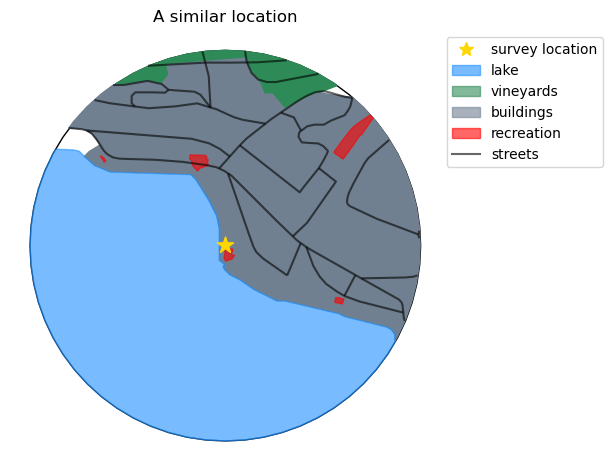

In [6]:
random_loc = similar.location.values[0]
lat, lon = lat_lon.loc[random_loc,['latitude', 'longitude']]
arandompoint = RandomPointLanduse(random_loc, lat, lon, 'l')
t = arandompoint.buffer_composition_proportions()
plot_buffer_content(arandompoint, title='A similar location') 

In [7]:
t[t.location == random_loc]

,location,vineyards,lake,buildings,recreation,streets
0,arabie,0.069983,1.061684,0.914234,0.014763,17114.587103


## Minimum Expected values

_The expected values are the minimum pcs/m we expect to find based on the survey results from similar locations._

> In the case of locations that were previously sampled the minimum expected value is the conditional probability given the results from the location of interest and the results from similar locations.

### For locations that have never been sampled

The expected values or forecasts for a location that has never been sampled is the distribution of previous survey results from locations that meet the similarity threshold. 

In [8]:
sampled_data[['pcs/m']].describe()

,pcs/m
count,50.000000
mean,1.161000
std,1.877075
min,0.000000
25%,0.162500
50%,0.450000
75%,1.150000
max,8.180000


(usingqgis)=
## Using QGIS

For this method we are using the land-cover layer from swissTLM regio

finished columns = slug, attribute , attribute_type, area, dry,	scale

In QGIS:

1. create a buffer around each survey point
   * make sure that the survey location and feature_type is in the attributes of the new buffer layer
   * the survey locations are loaded as points from .csv file
   * reproject the points layer to the project CRS 

2. use the new buffer layer as an overlay to the land-cover layer
   * use the overlay intersection tool
   * select the fields to keep from the buffer (slug and feature type)
   * select the fields to keep from the land-cover layer
   * run the function
   * this creates a temporary layer called _intersection_

3. get the surface area of all the land-cover and land-use features in each buffer of the temporary layer
   * use the field calculator for the attribute table of the layer
   * in the field calculator, make a new field and enter the formula `\$area`
   * for this example the method is elipsoid _bessel 1841 (epsg 7001)_
   * this is set in the properties of the QGIS project
   * Export the layer as .csv

4. verify the land-use features per location
   * drop duplicate values: use location, feature and area to define duplicates
   * attention! different names for lake and reservoir
     * change Stausee to See

5. make a dry land feature
   * this is the surface area of the buffer that is not covered by water
   * substract the area of See from the area of the buffer
   * identify survey locations that have siginifcant water features but are not listed as lakes
  
6. Scale the land-use attributes of interest to the available dry-land


In [9]:
%watermark -a hammerdirt-analyst -co --iversions

Author: hammerdirt-analyst

conda environment: cantonal_report

pandas    : 2.2.2
geopandas : 0.14.4
matplotlib: 3.8.4

